## Maaslin 2 Analysis of GO Terms for COVIRT19

 Lets install some R packages that we are gonna need to run this analysis

#if(!requireNamespace("BiocManager", quietly = TRUE))
#install.packages("BiocManager")

In [ ]:
#if (!requireNamespace("BiocManager", quietly = TRUE))
#BiocManager::install(c("Maaslin2", "DESeq2",'phyloseq','microbiome','DirichletMultinomial','GenomicRanges'))

In [ ]:
#install.packages("remotes")
#remotes::install_github("mikemc/speedyseq")
#install.packages(c('circlize','ggpubr','viridis','mosaic'))

Now lets load our libraries and set out environment

In [ ]:
library(tidyverse)
library(phyloseq)
library(microbiome)
library(DESeq2)
library(Maaslin2)
library(parallel)
library(DirichletMultinomial)
library(pheatmap)
library(ggpubr)
library(viridis)
library(mosaic)

In [ ]:
#'/home/jovyan/work/Aagaard_Raid3/microbial/GO_term_analysis/R_Maaslin2'

In [ ]:
getwd()
setwd('/media/jochum00/Aagaard_Raid3/jupyter_notebooks/jochum00_jupyter/microbial/GO_term_analysis/')

In [ ]:
raw<-as_tibble(read.table("Combined_BALF_GO_Terms_parent_propagated.tsv", sep = "\t", row.names = NULL, header = T, quote = "", comment.char = ""))

A tibble: 47,233 x 2,020     # good so far now
do a little regex and fix some stuff

In [ ]:
colnames(raw)<-gsub("NA_tax","unclass", colnames(raw))%>%str_replace_all("NC1_SRR7796663", "NC1.SRR7796663")

Transform the raw table by type of count (euk, term, bac, arc)

In [ ]:
df<-raw %>%
  select(GO_term,namespace,depth,name,ends_with("_counts"))%>%
  pivot_longer(cols = -c(GO_term,namespace,depth,name),
               names_to =  c("sample","type","abund"),#c("Total", "Archaea","Bacteria","Eukarya", "Viridae", "Unclassified"),
               names_pattern = "(.*)_(.*)_(.*)")%>%
  select(-abund)%>%
  filter(value>1)%>%
  pivot_wider(names_from = sample, values_from=value, values_fill=0)
#SIDE NOTE:There are multiple processes and values for a single sample so you cant convert the sample to columns

Make individual tibbles for biological processes and molecular fxn

In [ ]:
bio<-filter(df, namespace=="biological_process")
mol<-filter(df, namespace=="molecular_function")

make individual tibbles for each type (bac, euk, term, arc, vir, etc)

In [ ]:
bio_bac<-bio%>%filter(type=="bac")%>%select(-type)
bio_term<-bio%>%filter(type=="term")%>%select(-type)
mol_bac<-mol%>%filter(type=="bac")%>%select(-type)
mol_term<-mol%>%filter(type=="term")%>%select(-type)

subselect tibbles for only the counts and go terminology

In [ ]:
bio_bac_counts<-bio_bac%>%select(-c(namespace,depth,name))
bio_bac_tax<-bio_bac%>%select(GO_term,namespace,depth,name)
mol_bac_counts<-mol_bac%>%select(-c(namespace,depth,name))
mol_bac_tax<-mol_bac%>%select(GO_term,namespace,depth,name)

convert them to dataframes for downstream import to phylsoeq

In [ ]:
bio_bac_counts<-data.frame(bio_bac_counts, row.names=1)
bio_bac_tax<-data.frame(bio_bac_tax, row.names=1)
mol_bac_counts<-data.frame(mol_bac_counts, row.names=1)
mol_bac_tax<-data.frame(mol_bac_tax, row.names=1)

convert the dataframes into phyloseq formats

In [ ]:
bio_bac_counts_phy <- otu_table(bio_bac_counts, taxa_are_rows=TRUE)
bio_bac_tax_phy <- tax_table(as.matrix(bio_bac_tax), errorIfNULL=TRUE)
mol_bac_counts_phy<-otu_table(mol_bac_counts, taxa_are_rows = T)
mol_bac_tax_phy<-tax_table(as.matrix(mol_bac_tax), errorIfNULL = T)

import your metadata

In [ ]:
bio_bac_sam<-as.data.frame(read.table("Combined_BALF_GO_Terms_metadata2.txt",header = T, sep = "\t",row.names = 1))

a little regex to fix the stupid filename

In [ ]:
rownames(bio_bac_sam)<-rownames(bio_bac_sam)%>%str_replace_all("NC1_SRR7796663", "NC1.SRR7796663")
bio_bac_sam$accession<-rownames(bio_bac_sam)

I want to take a moment and thank the curators for all their hard work in annotation the metadata........ =)

In [ ]:
bio_bac_sam$outcome<-bio_bac_sam$outcome%>%
str_replace_all("recovered", "Recovered")%>%
str_replace_all("deceased","Deceased")%>%
str_replace_all('stabilized',"Stabilized")
###DONT FORGET TO DELETE THESE LINES LATER AFTER YOUR DONE PLAYING AROUND
#str_replace_all('Stabilized',"Survived")%>%
#str_replace_all("Recovered", "Survived")
###############################################

In [ ]:
bio_bac_sam$sex<-bio_bac_sam$sex%>%
str_replace_all("M", "male")%>%
str_replace_all("F", "female")%>%
str_replace_all("na", "<NA>")
tally(~sex,bio_bac_sam)

In [ ]:
tally(~case,bio_bac_sam,format = "data.frame")
tally(~sample_type,bio_bac_sam,format = "data.frame")
tally(~outcome,bio_bac_sam, format = "data.frame")
tally(~publication, bio_bac_sam, format="data.frame")

making physeq object

In [ ]:
bio_bac_pseq <- phyloseq(bio_bac_counts_phy, bio_bac_tax_phy, sample_data(bio_bac_sam))
mol_bac_pseq<-phyloseq(mol_bac_counts_phy,mol_bac_tax_phy, sample_data(bio_bac_sam))
bac_pseq<-merge_phyloseq(bio_bac_pseq,mol_bac_pseq)
bac_pseq

In [ ]:
filtme<-c("GO:0003674")
bac_pseq <- prune_taxa(taxa=taxa_names(bac_pseq)!=filtme, bac_pseq)
filtme<-c("GO:0008150")
bac_pseq <- prune_taxa(taxa=taxa_names(bac_pseq)!=filtme, bac_pseq)
bac_pseq

filter out the negative control and unknown samples

In [ ]:
bac_pseq_no_neg<-subset_samples(bac_pseq, sample_type!="neg_control")
bac_pseq_no_neg# [ 13846 taxa and 162 samples ]:
bac_pseq_no_neg<-subset_samples(bac_pseq_no_neg, sample_type!="Unknown")
bac_pseq_no_neg# [ 13846 taxa and 141 samples ]:
bac_pseq_no_sick<-subset_samples(bac_pseq_no_neg, case!="Control_Sick")
bac_pseq_no_sick# [ 13846 taxa and 141 samples ]:

Lets also remove the Micalovich samples for now

In [ ]:
bac_pseq_no_sick<-subset_samples(bac_pseq_no_neg, publication!="Michalovich")
bac_pseq_no_sick# [ 13846 taxa and 141 samples ]:

Lets change the names of the Go Terms so we can understand the description as well as the tag

This code was causing mismatches with name and GO TAG and has since been resolved 19 NOV 2020

In [ ]:
#names<-paste(taxa_names(bac_pseq_no_neg),get_taxa_unique(bac_pseq_no_neg,taxonomic.rank = "name" ),sep = "-")
#taxa_names(bac_pseq_no_neg)<-names

NEW and improved code

In [ ]:
tax<-data.frame(tax_table(bac_pseq_no_neg))
names<-paste(rownames(tax),tax$name,sep="-")
length(names)
taxa_names(bac_pseq_no_neg)<-names

In [ ]:
tax<-data.frame(tax_table(bac_pseq_no_sick))
names<-paste(rownames(tax),tax$name,sep="-")
length(names)
taxa_names(bac_pseq_no_sick)<-names
bac_pseq_no_sick_comp<-microbiome::transform(x = bac_pseq_no_sick,transform = "compositional")

# DESeq2 VST transformation

In [ ]:
sample_info_tab<-sample_data(bac_pseq_no_sick)
sample_info_tab_phy <- sample_data(sample_info_tab)

In [ ]:
deseq_counts<-phyloseq_to_deseq2(physeq = bac_pseq_no_sick,design = ~ 1) 

In [ ]:
deseq_counts_vst<-varianceStabilizingTransformation(deseq_counts)

In [ ]:
vst_trans_count_tab <- assay(deseq_counts_vst)

In [ ]:
#sample_info_tab<-sample_data(bac_pseq_no_neg)
#sample_info_tab_phy <- sample_data(sample_info_tab)
#deseq_counts<-phyloseq_to_deseq2(physeq = bac_pseq_no_neg,design = ~ 1) 
#deseq_counts_vst <- estimateSizeFactors(deseq_counts, type = "poscounts")
#vst_trans_count_tab <- assay(deseq_counts_vst)

#YAAAAAAAAAAAAAAAASSSSSSSSSSSSS THANK YOU LIMMMA

Dont worry about the limma batch effect correction step, I think I found a better way by including it in the multivariate model 

In [ ]:
#vst_trans_count_tab2 <- limma::removeBatchEffect(vst_trans_count_tab, sample_info_tab$publication)

IT FIXED THE BATCH EFFECT!

### convert the normalized counts to a phyloseq object and transform into relative abundances

In [ ]:
vst_count_phy <- otu_table(vst_trans_count_tab, taxa_are_rows=T)
vst_tax_phy <- tax_table(bac_pseq_no_sick)
vst_physeq <- phyloseq(vst_count_phy, vst_tax_phy,sample_data(bac_pseq_no_sick))
vst_physeq_comp<-microbiome::transform(x = vst_physeq,transform = "compositional")

# MaAsLIN2

In [ ]:
#head(abundances(vst_physeq))
#head(abundances(bac_pseq_no_sick))

#dir.create("R_Maaslin2") # Create a new directory
#setwd("/home/jovyan/work/Jochum_3/jupyter_lab/GO_term_analysis/R_Maaslin2/") # Change the current working directory 
getwd() #check if directory has been successfully changed

In [ ]:
df_input_data<-data.frame(t(otu_table(bac_pseq_no_sick_comp)))
df_input_metadata<-data.frame(sample_data(bac_pseq_no_sick_comp))

In [ ]:
df_input_data2<-data.frame(t(otu_table(vst_physeq)))
df_input_metadata2<-data.frame(sample_data(vst_physeq))

In [ ]:
#class(df_input_metadata2$case)
#df_input_metadata2$age<-as.factor(df_input_metadata2$age)
#df_input_metadata2$temp_degC<-as.factor(df_input_metadata2$temp_degC)
#df_input_metadata2$days.after.onset<-as.factor(df_input_metadata2$days.after.onset)
#df_input_metadata2$case<-factor(x = df_input_metadata2$case, levels = c("COVID19","Community_acquired_pneumonia","Control_Sick","Control_Healthy"))
#df_input_metadata2$outcome<-factor(x = df_input_metadata2$outcome, levels = c("Deceased","Stabilized","Recovered"))
#class(df_input_metadata2$case)
#df_input_metadata2$case

## ok so here are the parameters you want to manipulate:
min abundance= the min rel abund hits (1%) #filters out XXXX GO_terms \
min prevalence = Min samples required with min abundance for a feature not to be filtered (0.1=10%=14.1000 samples) \
max_significance = the maximinum p adjusted value to be significant \

This will filter out 13770 GO TERMS \

#_normalization = CLR transformation_ \
##### CORRECTION dont normalize here, just use the VST transformed counts
correction = the mutliple test correction method to be done (BH=Benjamini-Hochberg)

This is what is looks like if we feed the VST normalized counts into maaslin and get log scale outputs

`case<-Maaslin2(
  input_data = df_input_data2,
  input_metadata = df_input_metadata2,
  output="./vst_case_no_sick",
  min_abundance = 3,
  min_prevalence = 0.1, #minimimum presences 10.5 samples
  normalization = "NONE",
  transform = "NONE",
  analysis_method = "LM",
  max_significance = 0.001,
  #random_effects = c("sample_name","publication","collection_location","sequence_type"),
  random_effects = c("sample_name","publication"),
  fixed_effects = c("case"),
  correction="BH",
  standardize = TRUE,
  cores = 48,
  plot_heatmap = TRUE,
  plot_scatter = TRUE,
  heatmap_first_n = 100,
  reference=c("case,COVID19"))`

Ok this isnt working, I cant figure out how to not get >500 hits with the vst physeq object, and it doend tmake a lot of sense that everything is wayyy up but w/e.  

I think we could take these results and then go make boxplots of the compositionally transformed counts

Lets see what this looks like if we just let maaslin2 do the normalization (CLR) on compositionally transformed counts

In [ ]:
case_norm<-Maaslin2(
  input_data = df_input_data,
  input_metadata = df_input_metadata,
  output="./case_norm_no_sick",
  min_abundance = 0.01, #miminum rel. abundance 1%
  min_prevalence = 0.1, #minimimum presences 10.5 samples
  normalization = "CLR",
  transform = "NONE",
  analysis_method = "LM",
  max_significance = 0.05,
  #random_effects = c("sample_name","publication","collection_location","sequence_type"),
  random_effects = c("sample_name","publication"),
  fixed_effects = c("case"),
  correction="BH",
  standardize = TRUE,
  cores = 48,
  plot_heatmap = TRUE,
  plot_scatter = TRUE,
  heatmap_first_n = 100,
  reference=c("case,COVID19"))

wow that looks great, lets do it again for outcome
UPDATE: I decided to do this later with a subset of only COVID19 positive samples

`outcome<-Maaslin2(
  input_data = df_input_data,
  input_metadata = df_input_metadata,
  output="./outcome",
  min_abundance = 0.01,
  min_prevalence = 0.1,
  normalization = "CLR",
  transform = "NONE",
  analysis_method = "LM",
  max_significance = 0.05,
  #random_effects = c("sample_name","publication","collection_location","sequence_type"),
  random_effects = c("sample_name","publication"),
  fixed_effects = c("outcome"),
  correction="BH",
  standardize = TRUE,
  cores = 48,
  plot_heatmap = TRUE,
  plot_scatter = TRUE,
  heatmap_first_n = 100,
  reference=c("outcome,Deceased"))`

In [ ]:
#I need to figure out how to change how to pivot wider the case colum for an age analysis
df_input_metadata$age<-as.numeric(df_input_metadata$age)

age<-Maaslin2(
  input_data = df_input_data,
  input_metadata = df_input_metadata,
  output="./combined",
  min_abundance = 0.01,
  min_prevalence = 0.1,
  normalization = "CLR",
  transform = "NONE",
  analysis_method = "LM",
  max_significance = 0.25,
  #random_effects = c("sample_name","publication","collection_location","sequence_type"),
  random_effects = c("sample_name","publication"),
  fixed_effects = c("age"),
  correction="BH",
  standardize = TRUE,
  cores = 48,
  plot_heatmap = TRUE,
  plot_scatter = TRUE,
  heatmap_first_n = 100)#,
#  reference=c("outcome,Deceased"))

## MaAsLin2 outcome analyisis (pruned_samples)

In [ ]:
bac_pseq_outcome<-subset_samples(physeq = bac_pseq_no_sick,outcome!="NA")
#bac_pseq_outcome<-subset_samples(physeq = bac_pseq_no_neg, case=="COVID19")
bac_pseq_outcome
sample_info_tab<-sample_data(bac_pseq_outcome)
sample_info_tab_phy <- sample_data(sample_info_tab)
deseq_counts<-phyloseq_to_deseq2(physeq = bac_pseq_outcome,design = ~ 1)
deseq_counts_vst<-varianceStabilizingTransformation(deseq_counts)
#deseq_counts_vst <- estimateSizeFactors(deseq_counts, type = "poscounts")
vst_trans_count_tab <- assay(deseq_counts_vst)
vst_count_phy <- otu_table(vst_trans_count_tab, taxa_are_rows=T)
vst_tax_phy <- tax_table(bac_pseq_no_neg)
vst_physeq <- phyloseq(vst_count_phy, vst_tax_phy,sample_data(bac_pseq_outcome))
vst_physeq_comp<-microbiome::transform(x = vst_physeq,transform = "compositional")
#df_input_data<-data.frame(t(otu_table(vst_physeq_comp)))
#df_input_metadata<-data.frame(sample_data(vst_physeq_comp))
bac_pseq_outcome_comp<-microbiome::transform(x = bac_pseq_outcome,transform = "compositional")
df_input_data<-data.frame(t(otu_table(bac_pseq_outcome_comp)))
df_input_metadata<-data.frame(sample_data(bac_pseq_outcome_comp))

#### ok thats interesting it looks like it just through everything else into NA regardless of case... I guess lets trying it again with only covid cases

In [ ]:
#df_input_metadata$age<-as.numeric(df_input_metadata$age)
subset_outcome<-Maaslin2(
  input_data = df_input_data,
  input_metadata = df_input_metadata,
  output="./subset_outcome",
  min_abundance = 0.001,
  min_prevalence = 0.1,
  normalization = "CLR",
  transform = "NONE",
  analysis_method = "LM",
  max_significance = 0.5,
  random_effects = c("sample_name","publication"),
  fixed_effects = c("outcome"),
  correction="BH",
  standardize = TRUE,
  cores = 48,
  plot_heatmap = TRUE,
  plot_scatter = TRUE,
  heatmap_first_n = 100,
  reference="outcome,Deceased")

## DMM modeling using the MaAslin2 derived terms

Ok, lets import the MaAsLin2 derived significant terms

In [ ]:
case$results

In [393]:
res<-case_norm$results%>%filter(pval<=0.05)

## DMM Preprocessing /filtering

Ok lets filter out the GO_tag mataches from our phyloseq object

In [404]:
Terms<-gsub("GO.","GO:",res$feature)
Terms<-gsub("[.]"," ",Terms)
Terms<-sub(" ","-",Terms)
Terms<-as_tibble(Terms)
Terms<-separate(data = Terms,col = value,sep = "-",into =  c("Term", "name"))

In [410]:
bac_pseq_no_neg<-subset_samples(bac_pseq, sample_type!="neg_control")
bac_pseq_no_neg<-subset_samples(bac_pseq_no_neg, sample_type!="Unknown")
bac_pseq_no_neg #[ 13846 taxa and 141 samples ]:
bac_pseq_no_sick<-subset_samples(bac_pseq_no_neg, case!="Control_Sick")
bac_pseq_no_sick# [ 13846 taxa and 141 samples ]:
bac_pseq_no_sick<-subset_samples(bac_pseq_no_sick, publication!="Michalovich")
bac_pseq_no_sick# [ 13846 taxa and 141 samples ]:

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13844 taxa and 141 samples ]
sample_data() Sample Data:       [ 141 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13844 taxa by 3 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13844 taxa and 105 samples ]
sample_data() Sample Data:       [ 105 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13844 taxa by 3 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13844 taxa and 102 samples ]
sample_data() Sample Data:       [ 102 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13844 taxa by 3 taxonomic ranks ]

In [416]:
bac_pseq_prune <- prune_taxa(taxa = Terms$Term,x =bac_pseq_no_sick)
bac_pseq_prune #[85 taxa and 141 samples ]
bac_pseq_prune<-prune_taxa(taxa_sums(bac_pseq_prune)>0,bac_pseq_prune)
bac_pseq_prune
bac_pseq_prune<-prune_samples(sample_sums(bac_pseq_prune)>0,bac_pseq_prune)
bac_pseq_prune<-prune_taxa(taxa_sums(bac_pseq_prune)>0,bac_pseq_prune)
bac_pseq_prune

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19 taxa and 102 samples ]
sample_data() Sample Data:       [ 102 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 19 taxa by 3 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19 taxa and 102 samples ]
sample_data() Sample Data:       [ 102 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 19 taxa by 3 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19 taxa and 100 samples ]
sample_data() Sample Data:       [ 100 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 19 taxa by 3 taxonomic ranks ]

Ok lets fix our names again

In [417]:
tax<-data.frame(tax_table(bac_pseq_prune))
names<-paste(rownames(tax),tax$name,sep="-")
taxa_names(bac_pseq_prune)<-names

#### DMM modeling time

convert counts to a matrix

In [418]:
dat <- abundances(bac_pseq_prune)
count <- as.matrix(t(dat))

Fit the dmm model

In [420]:
library(parallel)
fit <- lapply(1:8, dmn, count = count, verbose=TRUE)

dmn, k=1



  Soft kmeans
  Expectation Maximization setup
  Expectation Maximization
  Hessian


dmn, k=2



  Soft kmeans
    iteration 10 change 0.000687
    iteration 20 change 0.000307
    iteration 30 change 0.000209
    iteration 40 change 0.000173
    iteration 50 change 0.000166
    iteration 60 change 0.000185
    iteration 70 change 0.000244
    iteration 80 change 0.000402
    iteration 90 change 0.000986
    iteration 100 change 0.007505
    iteration 110 change 0.000961
  Expectation Maximization setup
  Expectation Maximization
    iteration 10 change 0.000029
  Hessian


dmn, k=3



  Soft kmeans
    iteration 10 change 0.045465
    iteration 20 change 0.007249
    iteration 30 change 0.000605
    iteration 40 change 0.000020
  Expectation Maximization setup
  Expectation Maximization
    iteration 10 change 0.000973
  Hessian


dmn, k=4



  Soft kmeans
    iteration 10 change 0.208561
    iteration 20 change 0.006561
    iteration 30 change 0.000030
  Expectation Maximization setup
  Expectation Maximization
    iteration 10 change 0.424258
  Hessian


dmn, k=5



  Soft kmeans
    iteration 10 change 0.003130
    iteration 20 change 0.000128
    iteration 30 change 0.000118
    iteration 40 change 0.000088
    iteration 50 change 0.000055
    iteration 60 change 0.000030
    iteration 70 change 0.000015
    iteration 80 change 0.000007
    iteration 90 change 0.000003
    iteration 100 change 0.000002
  Expectation Maximization setup
  Expectation Maximization
    iteration 10 change 0.005046
  Hessian


dmn, k=6



  Soft kmeans
    iteration 10 change 0.001089
    iteration 20 change 0.000348
    iteration 30 change 0.000083
    iteration 40 change 0.000019
    iteration 50 change 0.000004
    iteration 60 change 0.000001
  Expectation Maximization setup
  Expectation Maximization
    iteration 10 change 2.120760
  Hessian


dmn, k=7



  Soft kmeans
    iteration 10 change 0.001774
    iteration 20 change 0.001176
    iteration 30 change 0.000575
    iteration 40 change 0.000269
    iteration 50 change 0.000117
    iteration 60 change 0.000048
    iteration 70 change 0.000020
    iteration 80 change 0.000008
    iteration 90 change 0.000003
    iteration 100 change 0.000001
  Expectation Maximization setup
  Expectation Maximization
    iteration 10 change 13.531394
    iteration 20 change 0.374626
    iteration 30 change 0.002054
  Hessian


dmn, k=8



  Soft kmeans
    iteration 10 change 0.001231
    iteration 20 change 0.000499
    iteration 30 change 0.000237
    iteration 40 change 0.000076
    iteration 50 change 0.000021
    iteration 60 change 0.000006
    iteration 70 change 0.000001
  Expectation Maximization setup
  Expectation Maximization
    iteration 10 change 10.207817
    iteration 20 change 0.216248
    iteration 30 change 0.000479
    iteration 40 change 0.000235
    iteration 50 change 0.025432
    iteration 60 change 0.001503
  Hessian


Check the model fit with different number of mixture componenets using standard information criteria

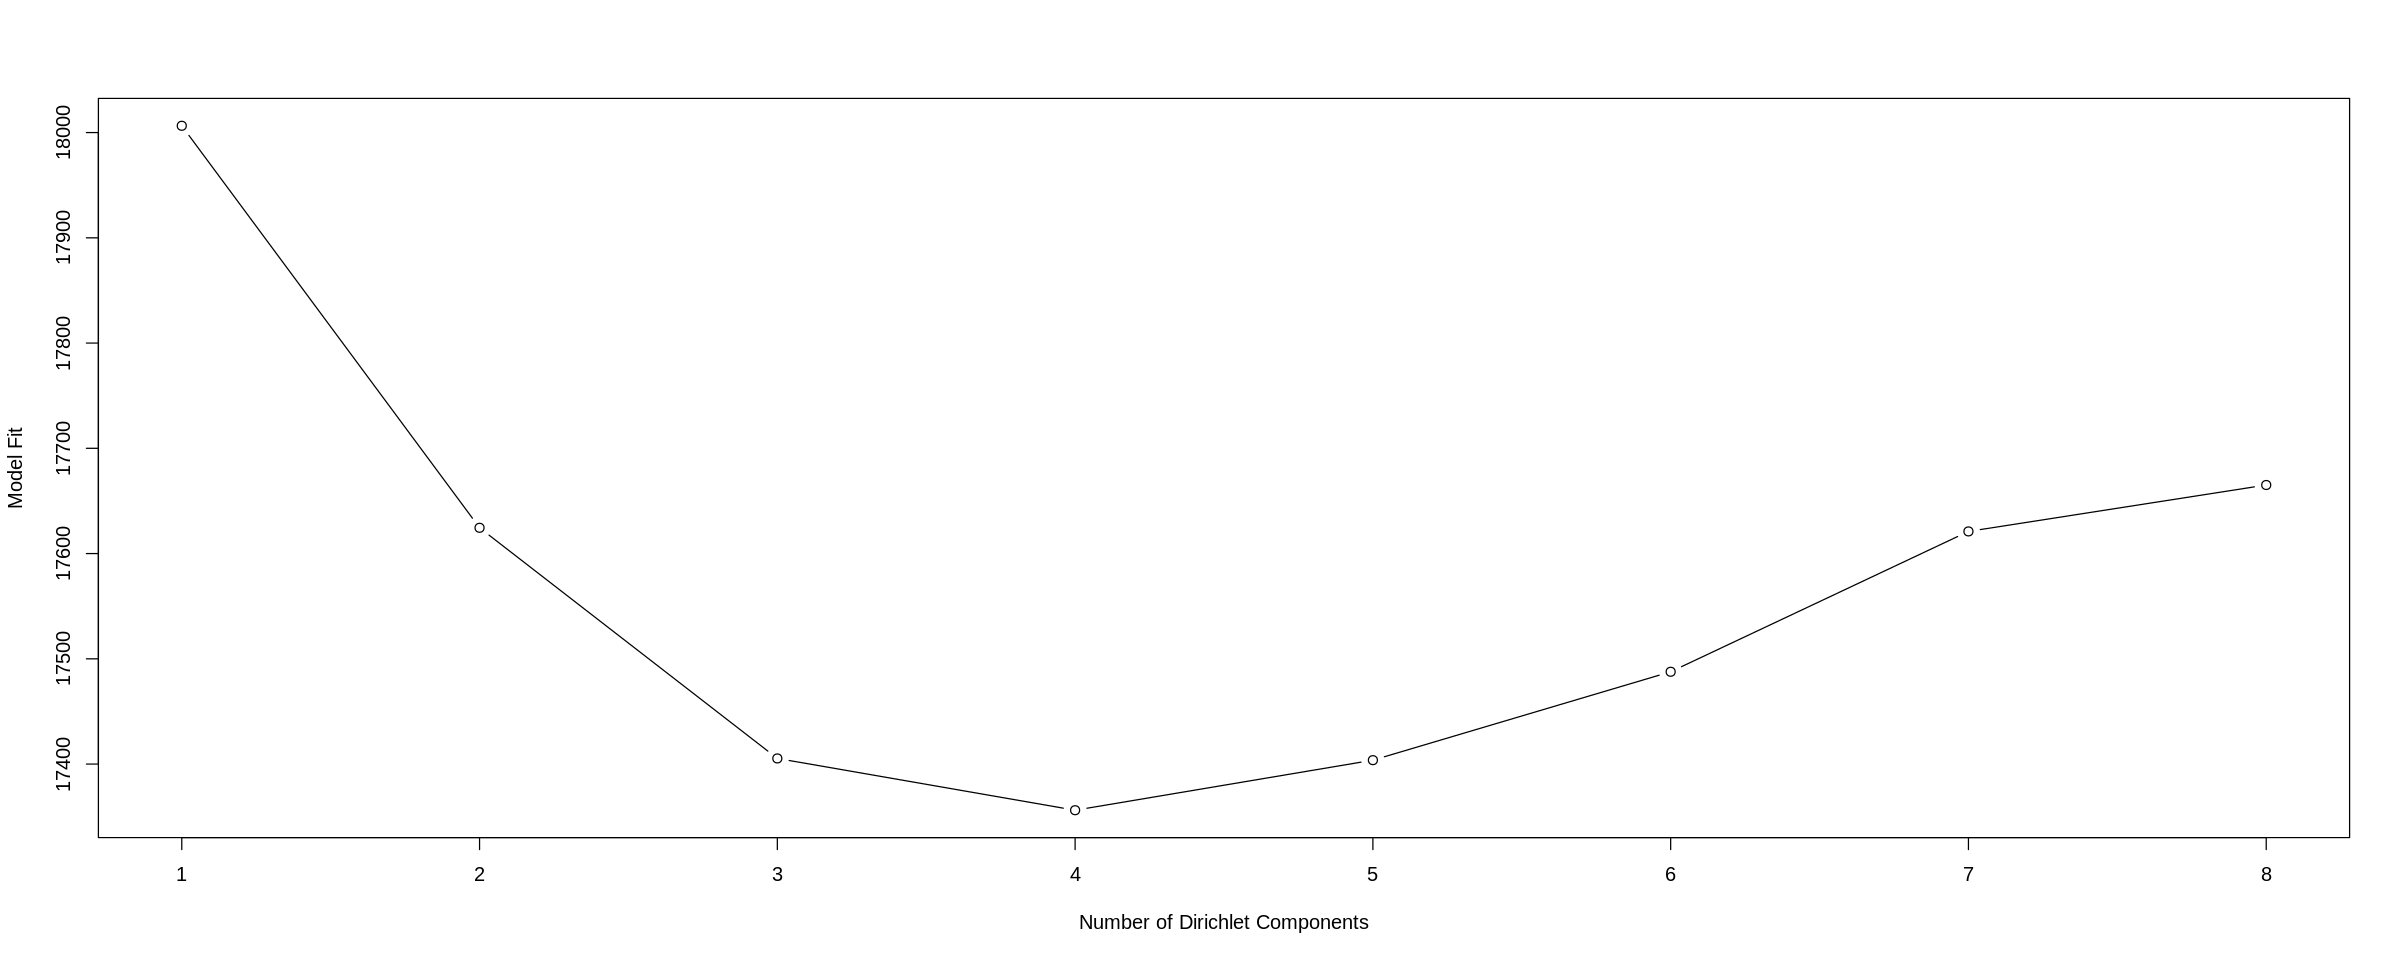

In [421]:
lplc <- sapply(fit, laplace) # AIC / BIC / Laplace
aic  <- sapply(fit, AIC) # AIC / BIC / Laplace
bic  <- sapply(fit, BIC) # AIC / BIC / Laplace
plot(lplc, type="b", xlab="Number of Dirichlet Components", ylab="Model Fit")

In [422]:
#identify the number of clusters that best fits the model

In [423]:
best <- fit[[which.min(lplc)]]
#best <-fit[[4]]
best

class: DMN 
k: 4 
samples x taxa: 100 x 19 
Laplace: 17356.14 BIC: 17282.23 AIC: 17179.32 

In [424]:
#save.image(file = "go_terms_dmm.rdata")

#make a heatmap visualization of the cluster

log 2 Heatmap

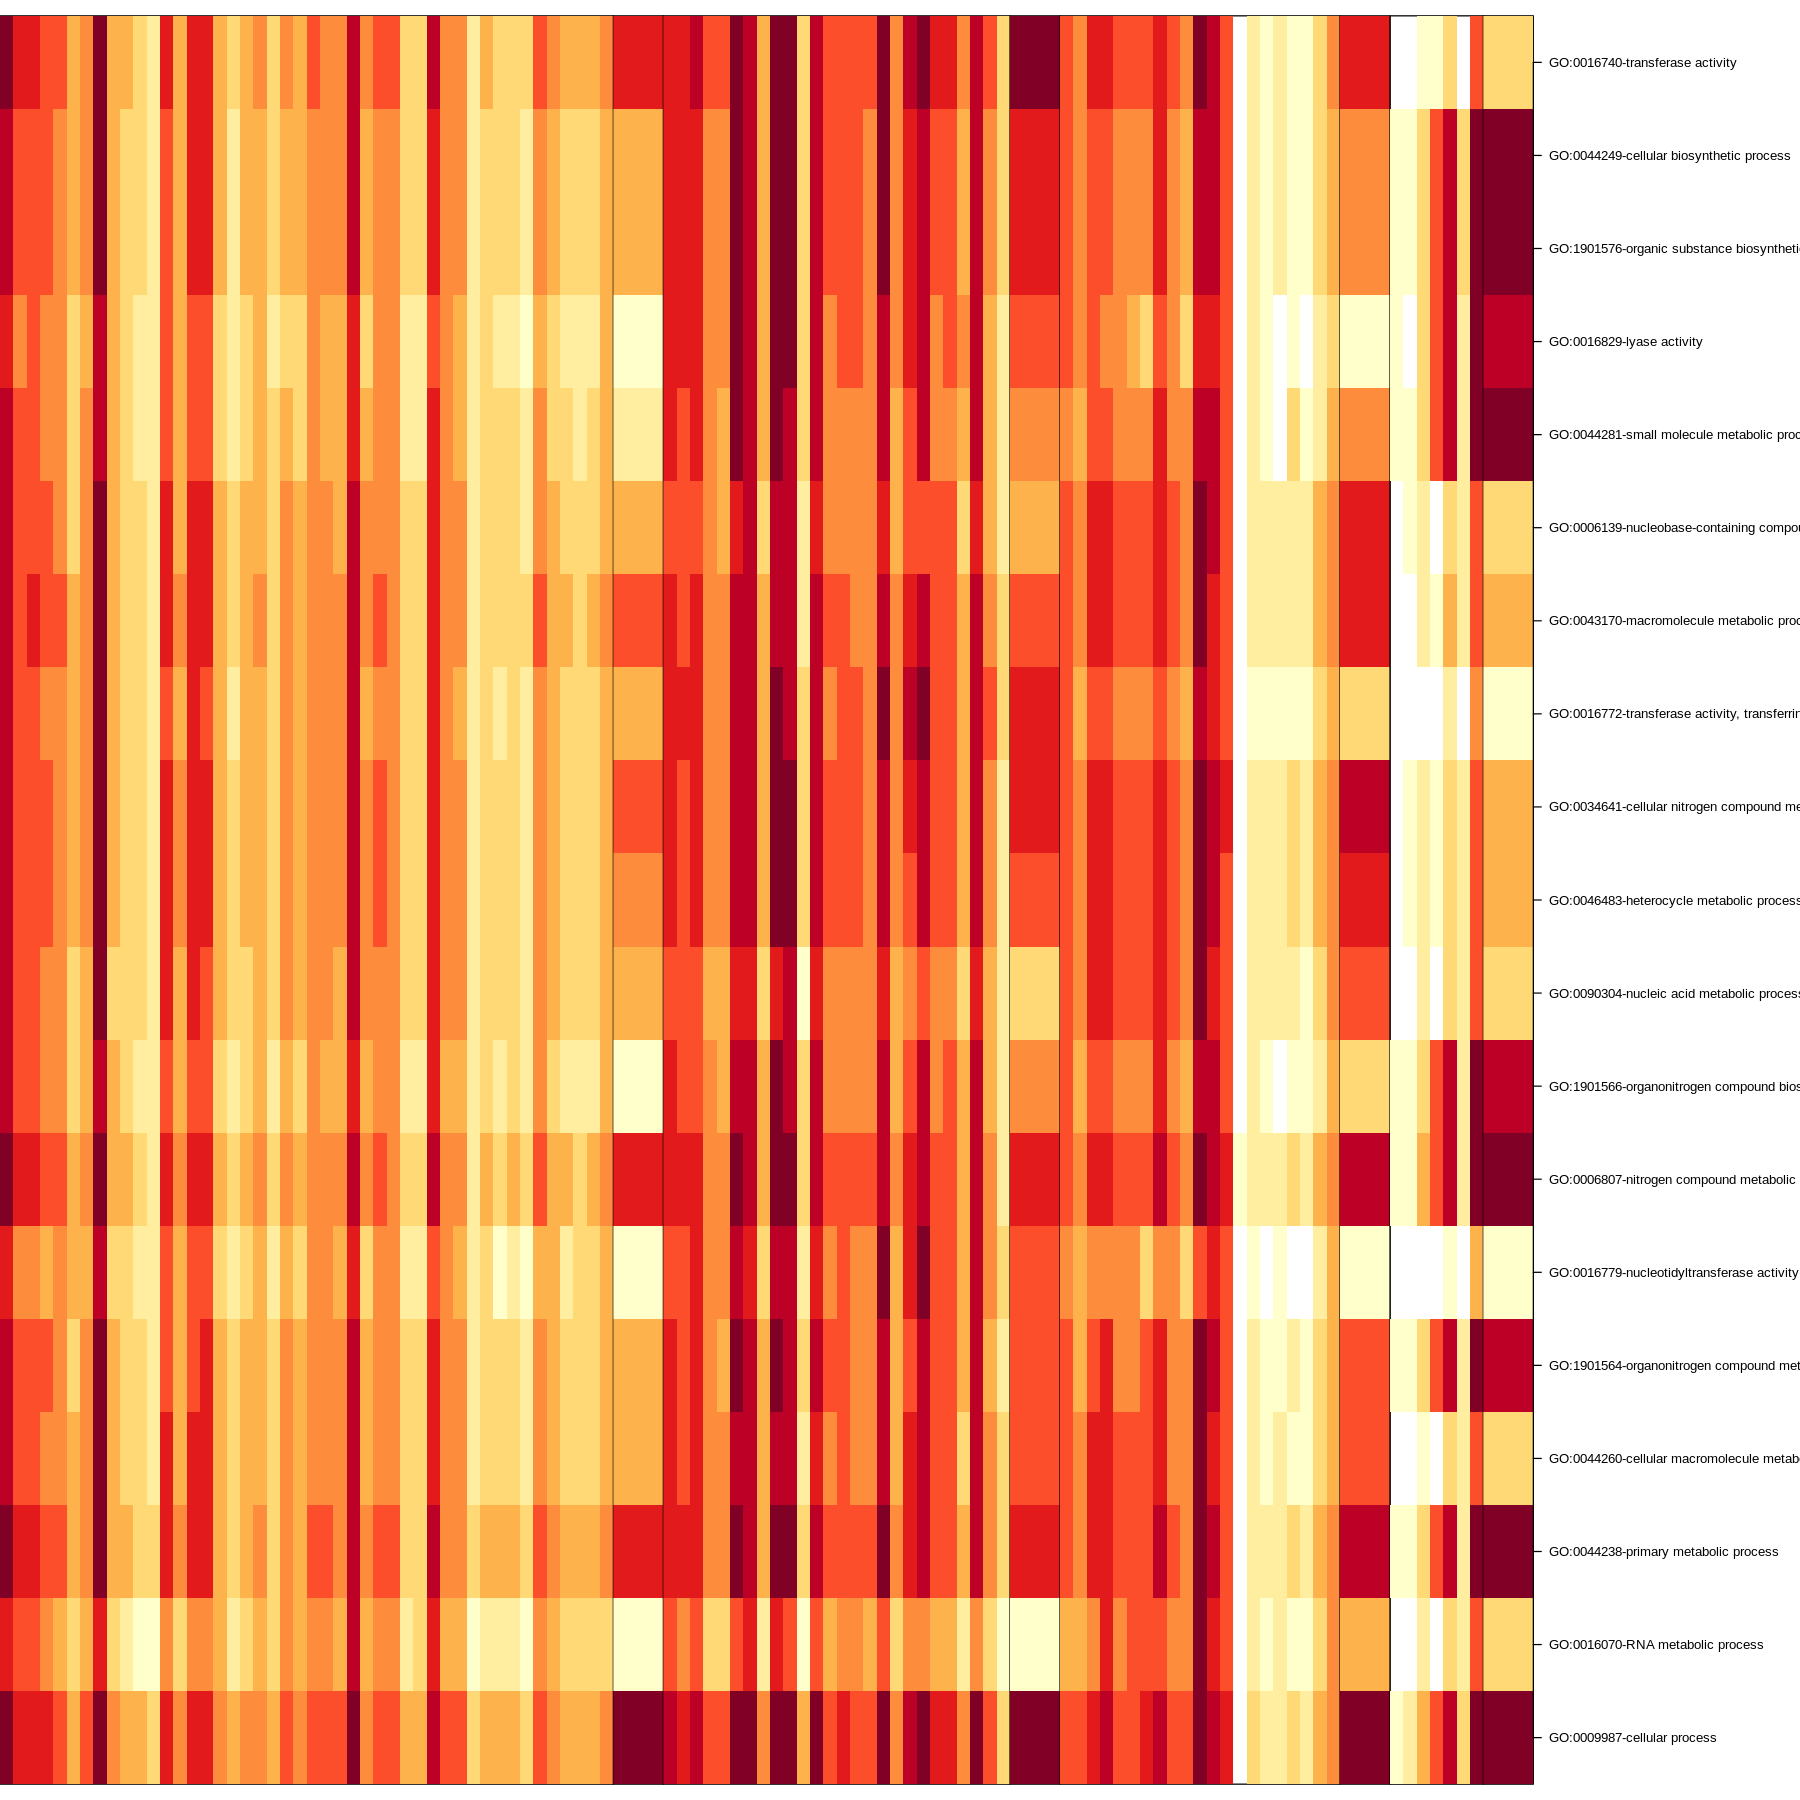

In [425]:
options(repr.plot.width=15, repr.plot.height=15)
heatmapdmn(count, fit[[1]], best,ntaxa = 50,
           transform =log2, lblwidth = 0.2 * nrow(count))

square root version

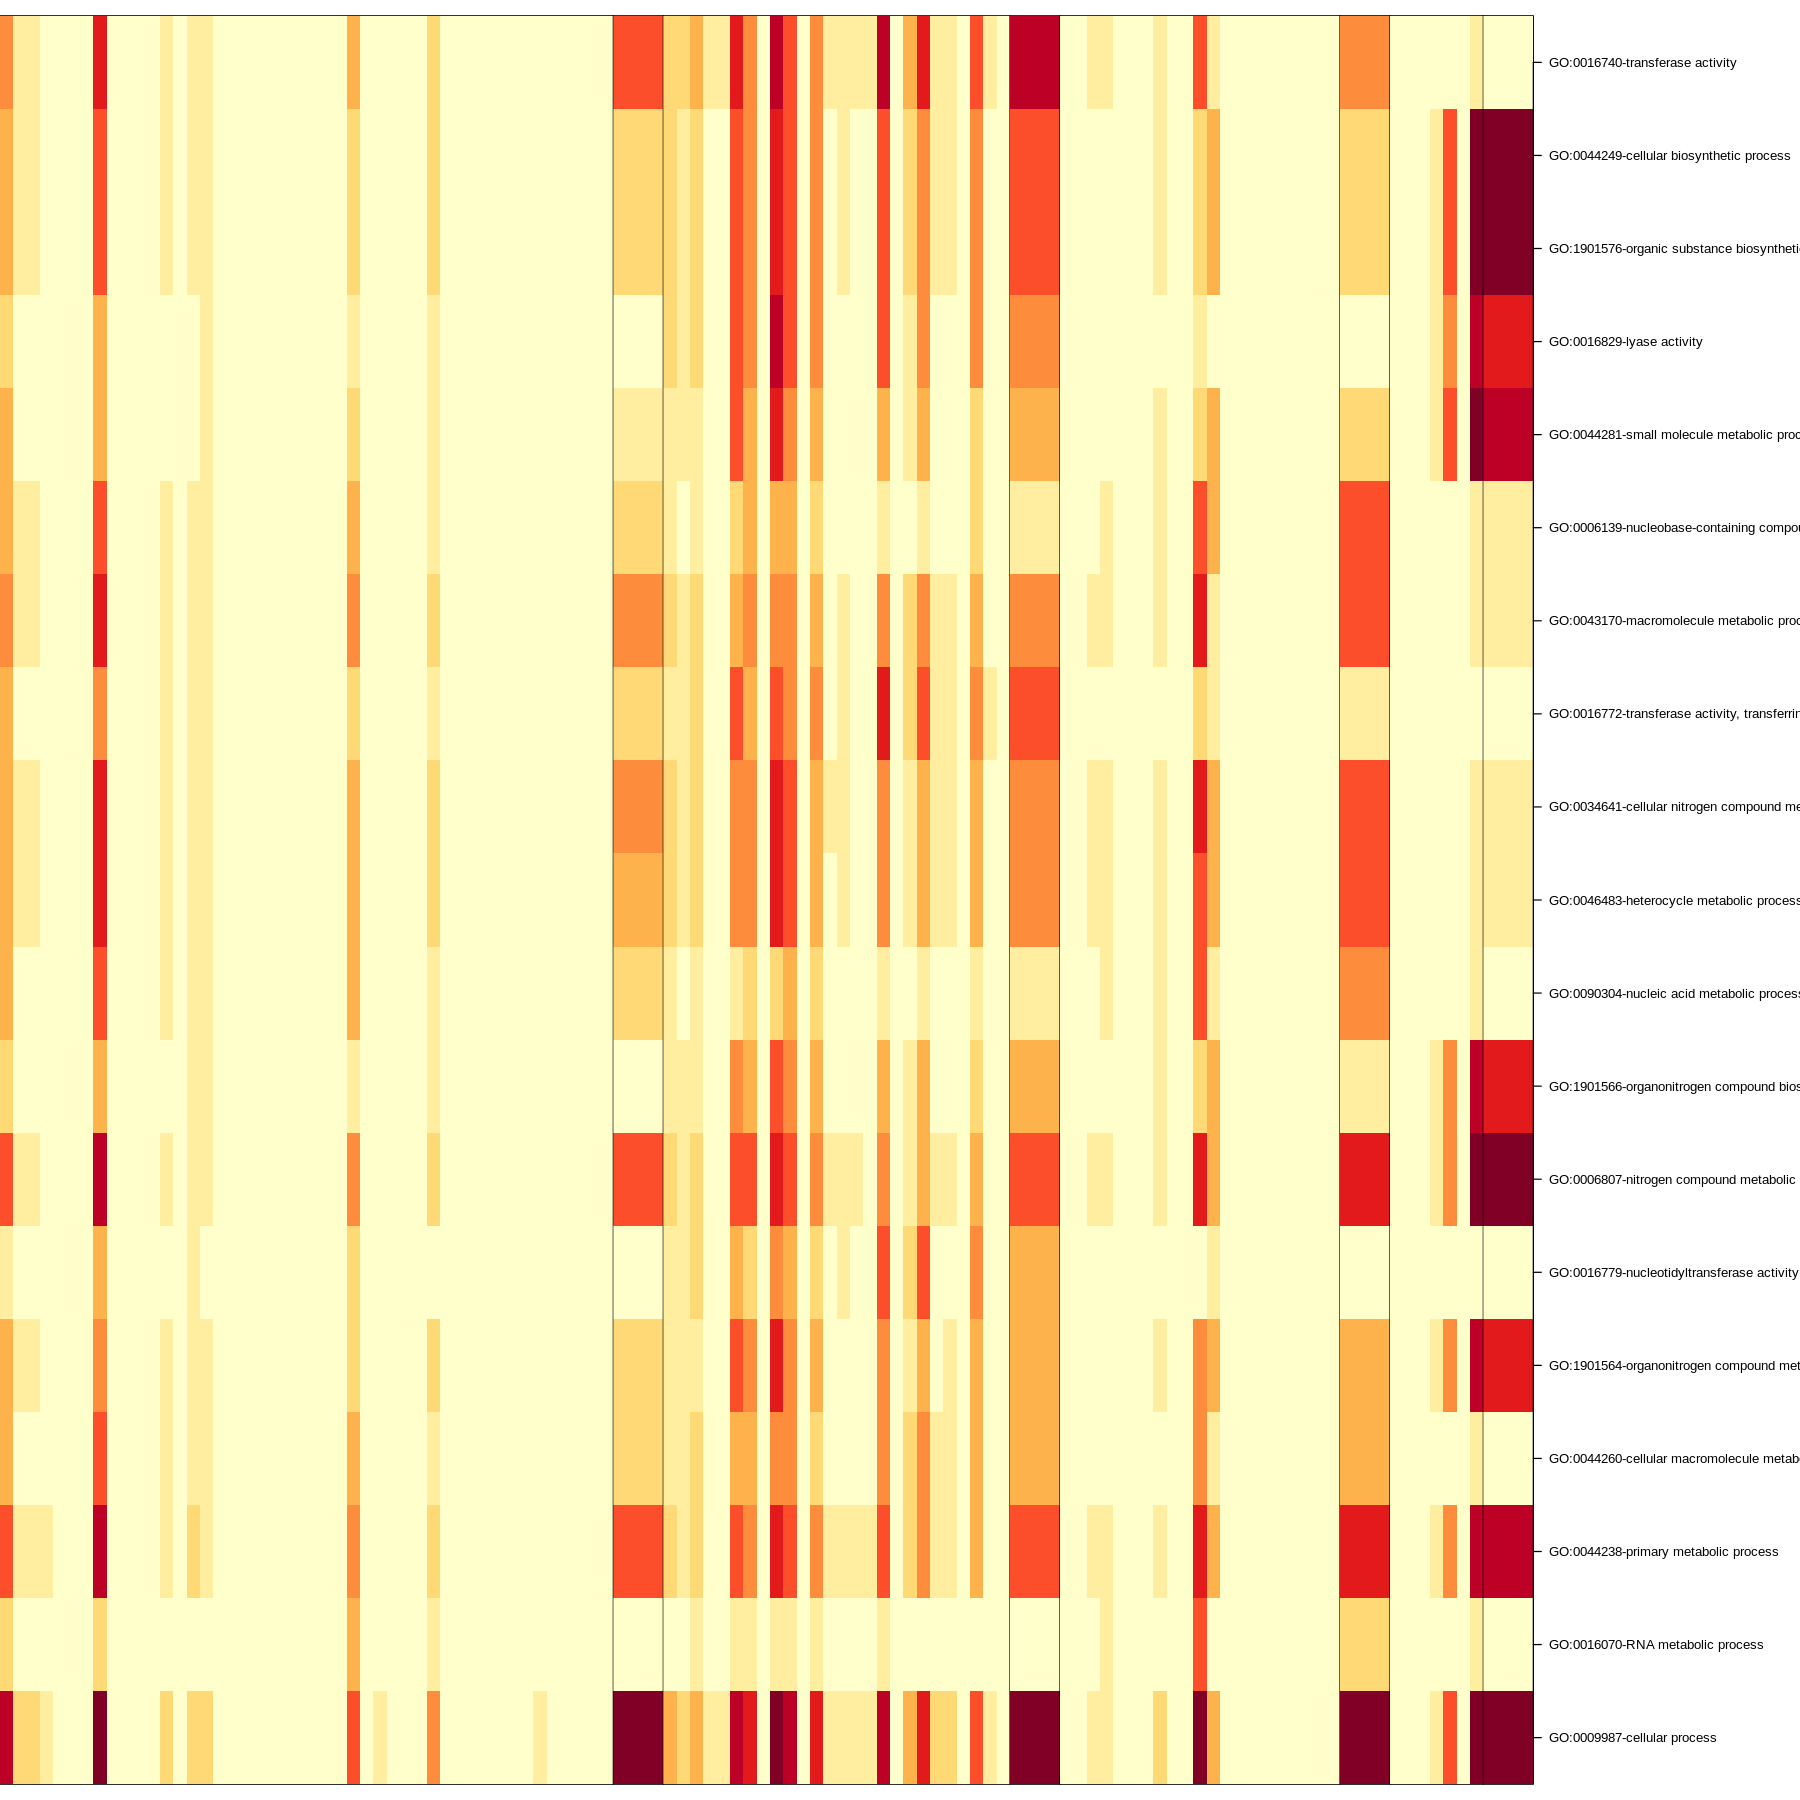

In [426]:
options(repr.plot.width=15, repr.plot.height=15)
heatmapdmn(count, fit[[1]], best,ntaxa = 50,
           transform =sqrt, lblwidth = 0.2 * nrow(count))

print out the theta values

In [427]:
mixturewt(best)

pi,theta
<dbl>,<dbl>
0.46685873,474.93453
0.26085282,281.66595
0.20282538,104.53549
0.06946308,84.69673


save the datasheet that show which GO terms contributed to each dmm group

In [428]:
write.table(fitted(best),"GO_TERMS_DMM_contributions.tsv", sep="\t")

save a datasheet that identifies which sample belongs to which dmm group

In [429]:
ass <- apply(mixture(best), 1, which.max)
write.table(ass,"GO_TERMS_DMM_groups.tsv",sep="")

In [430]:
#add the dmm group to the metadata
sample_data(bac_pseq_prune)$dmn<-ass
bac_pseq_prune_comp<-microbiome::transform(bac_pseq_prune,"compositional")
#melt the phyloseq object into tidy form
tmp<-psmelt(bac_pseq_prune_comp)
tmp<-as_tibble(tmp)

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 54 rows containing non-finite values (stat_bin).”


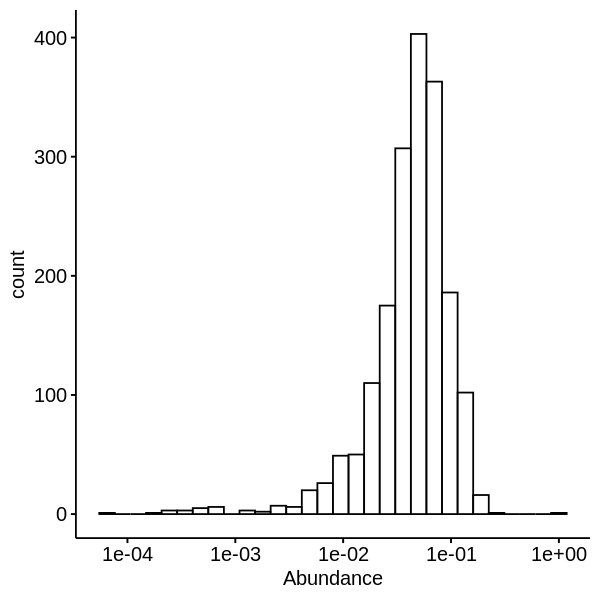

In [431]:
options(repr.plot.width=5, repr.plot.height=5)
gghistogram(tmp,x = "Abundance",y = "..count..")+scale_x_log10() #move each dmm group into a colum of its own

In [432]:
#tmp$log2Abundance<-log2(tmp$Abundance)

In [433]:
#subset the dataset to only include the case, Go_term, count, and dmm group.
#obtain the avergage count for each Go term
#order the go terms from hight to lowest count

I added these filtering commands to pull out the counts with less than 1% relabund or greater tahn 22% (ie:molecular function)

In [434]:
d2<-tmp %>%
  select(case,OTU,Abundance, dmn)%>%
  group_by(OTU,case, dmn) %>%
  summarise(avg = mean(Abundance)) %>%
  arrange(desc(avg))

`summarise()` regrouping output by 'OTU', 'case' (override with `.groups` argument)



In [435]:
#d2$avg<-sqrt(d2$avg)

In [436]:
#get the total count of the go terms and oder from greates to lowest


In [438]:
d3<-tidyr::spread(d2,dmn,avg)
d3$tot<-rowSums(d3[3:6], na.rm = T)
d3<-d3%>%arrange(desc(tot))
d3$tot<-NULL
head(d3)

OTU,case,1,2,3,4
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
GO:0009987-cellular process,COVID19,0.14669056,0.13075338,0.11753112,0.15751535
GO:0006807-nitrogen compound metabolic process,COVID19,0.08571085,0.07155771,0.18195097,0.11091934
GO:0009987-cellular process,Control_Healthy,0.14853682,0.13325469,0.15354996,NA
GO:0009987-cellular process,Community_acquired_pneumonia,0.16001172,0.13128418,0.13447047,NA
GO:0044238-primary metabolic process,COVID19,0.09423806,0.06420575,0.08996370,0.08870811
GO:0016740-transferase activity,Control_Healthy,0.09119047,0.12383228,0.06517963,NA


In [439]:
d3<-d3%>%gather(data = d3,avg,3:6)
colnames(d3)<-c("name","case", "dmn","avg")
d3

name,case,dmn,avg
<chr>,<chr>,<chr>,<dbl>
GO:0009987-cellular process,COVID19,1,0.14669056
GO:0006807-nitrogen compound metabolic process,COVID19,1,0.08571085
GO:0009987-cellular process,Control_Healthy,1,0.14853682
GO:0009987-cellular process,Community_acquired_pneumonia,1,0.16001172
GO:0044238-primary metabolic process,COVID19,1,0.09423806
GO:0016740-transferase activity,Control_Healthy,1,0.09119047
GO:0044238-primary metabolic process,Control_Healthy,1,0.08966901
GO:1901576-organic substance biosynthetic process,COVID19,1,0.04646098
GO:0044249-cellular biosynthetic process,COVID19,1,0.04560755


make the balloon plot

In [447]:
d4<-d3%>%filter(avg>0.01)%>%arrange(name,case,dmn)
#d4<-d4[1:108,]
dim(d4)
dim(d3)

[1] 176   4

[1] 228   4

In [448]:
my_pal<-viridis(n = 256, alpha = 1, begin = 0, end = 1, direction = 1)

Warning message:
“Removed 38 rows containing missing values (geom_point).”


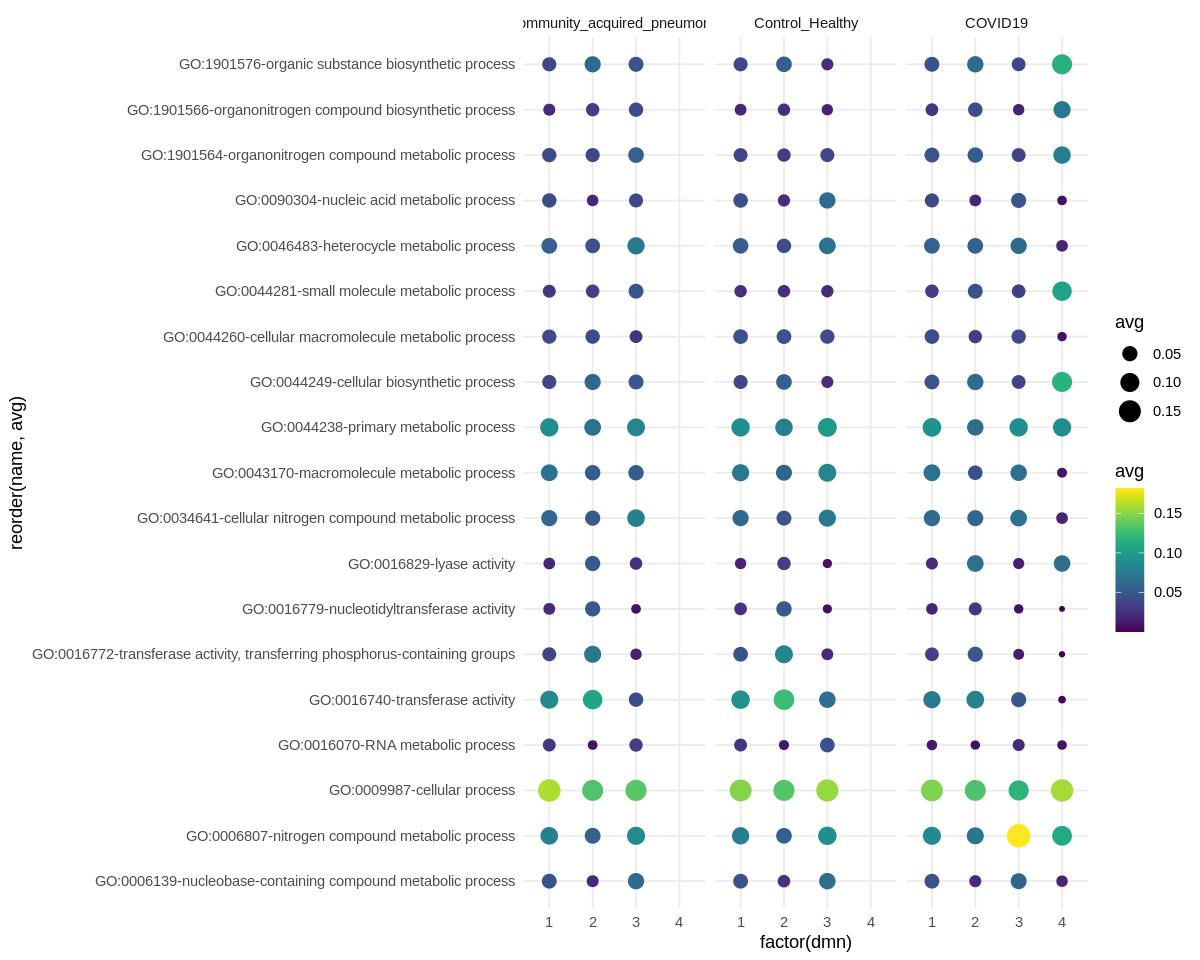

In [456]:
options(repr.plot.width=10, repr.plot.height=8)
a<-ggplot(data = d3,mapping = aes(x = factor(dmn),y =reorder(name,avg),size=avg,color=avg))+
geom_point()+
#theme(text=element_text(size=20))+
scale_colour_gradientn(colours = my_pal)+
facet_grid(facets = ~ case)+
theme_minimal()

a

Warning message:
“Removed 38 rows containing missing values (geom_point).”


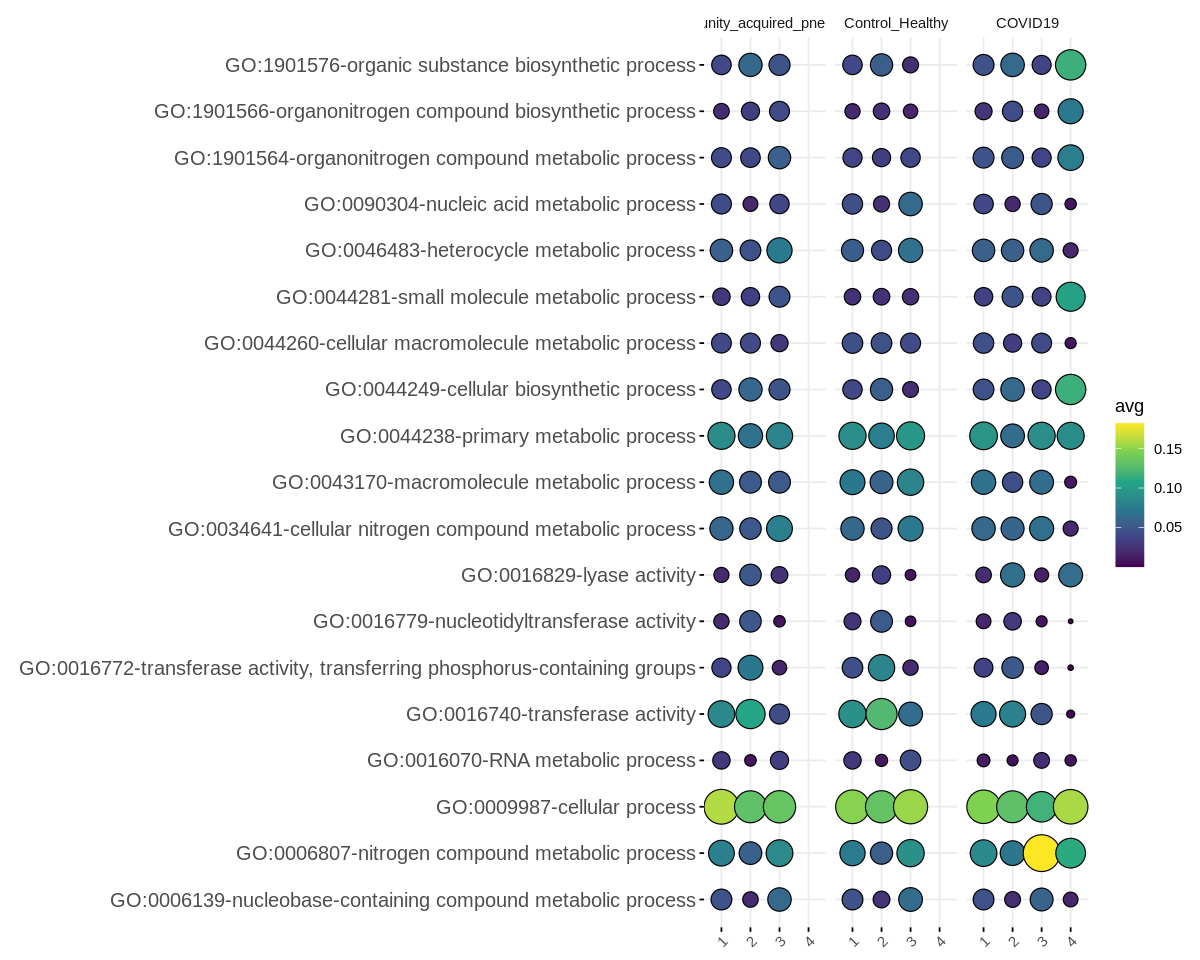

In [458]:
options(repr.plot.width=10, repr.plot.height=8)  
ggballoonplot(d3, y ="name",x = "dmn", size = "avg", facet.by = "case",fill = "avg",ggtheme = theme_minimal())+
     guides(size = FALSE)+
    font("y.text", size = 12)+scale_fill_viridis_c()

In [459]:
save.image("GO_TERM_Maaslin2_29_NOV_2020.rda")
#load.Rdata("GO_TERM_Maaslin2_19_NOV_2020.rda")

## DATA VISUALIZATION TIME and outcome comparison time

In [460]:
sam<-as_tibble(sample_data(bac_pseq_prune))
tbl<-tally(x = case~dmn,sam, format = "count")

Warning message in class(x) <- c(setdiff(subclass, tibble_class), tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”


In [461]:
case<-as.vector(tally(~case,sam))
case
dmn<-as.vector(tally(~dmn,sam))
dmn
cor.test(case,dmn)
cor(case,dmn)
cov(case,dmn)

[1] 25 29 46

[1] 46 26 21  7

ERROR: Error in cor.test.default(x, y, ...): 'x' and 'y' must have the same length


ok lets do a binomial test to see if we can use this

In [ ]:
out_tbl<-tally(x = case~dmn,sam)
result2 <-chisq.test(table(out_tbl))
out_tbl
result2
chisq(result2)

YAAAASSSSSS CASE ~OUTCOME Chi-squared TEST P=0.0517
LESGOOOO

## HEATMAP TIME

In [ ]:
###########################################
###Dont forget to save you shit HERE#######
###########################################
#save.image(file = "bac_go_terms_dmm.rdata")
#

In [472]:
count<-abundances(bac_pseq_prune)
select <- order(rowMeans(count),decreasing=TRUE)
select3<-order(rowSdDiffs(count),decreasing=T)
select2<-log1p((count)[select3,])
tmp<-rownames(select2)
dim(select2)

[1]  19 100

In [473]:
#select2$mol<-tmp
select_tibb<-as_tibble(select2)
rownames(select_tibb)<-rownames(select2)
write.table(select2,file = "GO_Terms_results")

Warning message:
“Setting row names on a tibble is deprecated.”


In [474]:
#library(matrixTests)
#library(genefilter)
#select3<-as_tibble(select2)%>%summarise(std=rowFtests(select2))%>% arrange(desc(std))
#select2$mol<-tmp
select2<-as_tibble(select2)
#select2$mean<-rowMeans(select2)

In [493]:
rownames(select2)<-tmp
sam<-data.frame(sample_data(bac_pseq_prune))
df<-as.data.frame(sample_data(bac_pseq_prune))
df<-as_tibble(df)
#df<-df%>%select(dmn, publication, sample_type,case,outcome)#dmn,body_site)
#update, removing sample type column after removing sick and micalovich samples
df<-df%>%select(dmn, publication, case,outcome)#dmn,body_site)
df<-as.data.frame(df)

Warning message:
“Setting row names on a tibble is deprecated.”
Warning message in class(x) <- c(setdiff(subclass, tibble_class), tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”


In [494]:
#select2<-sqrt((count)[select,])
dim(select2)
colnames(select2) <- colnames(otu_table(bac_pseq_prune))
length(rownames(select2))
length(row.names(df))
row.names(df) <- colnames(select2)

[1]  19 100

[1] 19

[1] 100

In [495]:
library(ggsci)

In [496]:
mypal <- pal_aaas("default", alpha = 1)(10)
mypal
library("scales")
library(RColorBrewer)
library(viridis)
library(pheatmap)
df_row<-as.data.frame(fitted(best))
#colnames(df_row)<-c("1","2","3","4","5","6")
df<-data.frame(df)
#update, removing sampleType column after removinch "sick" samples
#colnames(df)<-c("dmm_cluster", "Publication","Sample_Type","Case","Outcome")
colnames(df)<-c("dmm_cluster", "Publication","Case","Outcome")

[1] "#3B4992FF" "#EE0000FF" "#008B45FF" "#631879FF" "#008280FF" "#BB0021FF"
 [7] "#5F559BFF" "#A20056FF" "#808180FF" "#1B1919FF"

In [497]:
# Specify colors

In [498]:
ann_colors = list(
  dmm_cluster=c("1"="#3B4992FF","2"="#EE0000FF","3"="#008B45FF","4"="#631879FF","5"="#008280FF","6"="#BB0021FF","7"="#5F559BFF"),
  Publication=c("Xiong"="#008280FF", "Shen"="#631879FF","Michalovich"="#BB0021FF","Chen"="#3B4992FF","Wu"="#EE0000FF","Zhou"="orange","Ren"="#111111"),
  Sample_Type =c("COVID_19"="firebrick",
                 "Healthy"="forestgreen",
                 "Community_acquired_pneumonia"="darkorange1",
                 "Obese_Asthma"="goldenrod3",
                 "Obese_Smoker"="goldenrod4", 
                 "Obese"="goldenrod1",
                 "Asthma"= "dodgerblue2", 
                 "Asthma_Smoker"="dodgerblue4",
                 "Asthma_Ex_smoker"="dodgerblue3",
                 "Smoker"="gray27",
                 "Obese_Asthma_Smoker"="black"),
  Case=c("COVID19"="firebrick","Community_acquired_pneumonia"="darkorange1", "Control_Healthy"="forestgreen","Control_Sick"="dodgerblue4"),
Outcome=c("Deceased"="black","Stabilized"="goldenrod4","Recovered"="forestgreen"))

In [499]:
ann_colors = list(
  dmm_cluster=c("1"="#3B4992FF","2"="#EE0000FF","3"="#008B45FF","4"="#631879FF"),#,"5"="#008280FF","6"="#BB0021FF","7"="#5F559BFF"),
  Publication=c("Xiong"="#008280FF", "Shen"="#631879FF","Chen"="#3B4992FF","Wu"="#EE0000FF","Zhou"="orange","Ren"="#111111"),
  Case=c("COVID19"="firebrick","Community_acquired_pneumonia"="darkorange1", "Control_Healthy"="forestgreen"),
 # Sample_Type=c("COVID_19"="firebrick","Community_acquired_pneumonia"="darkorange1", "Healthy"="forestgreen"),
Outcome=c("Deceased"="black","Stabilized"="goldenrod4","Recovered"="forestgreen"))

In [500]:
select3<-select2%>%filter(rowMeans(select2)>8)
dim(select2)
dim(select3)

[1]  19 100

[1]  19 100

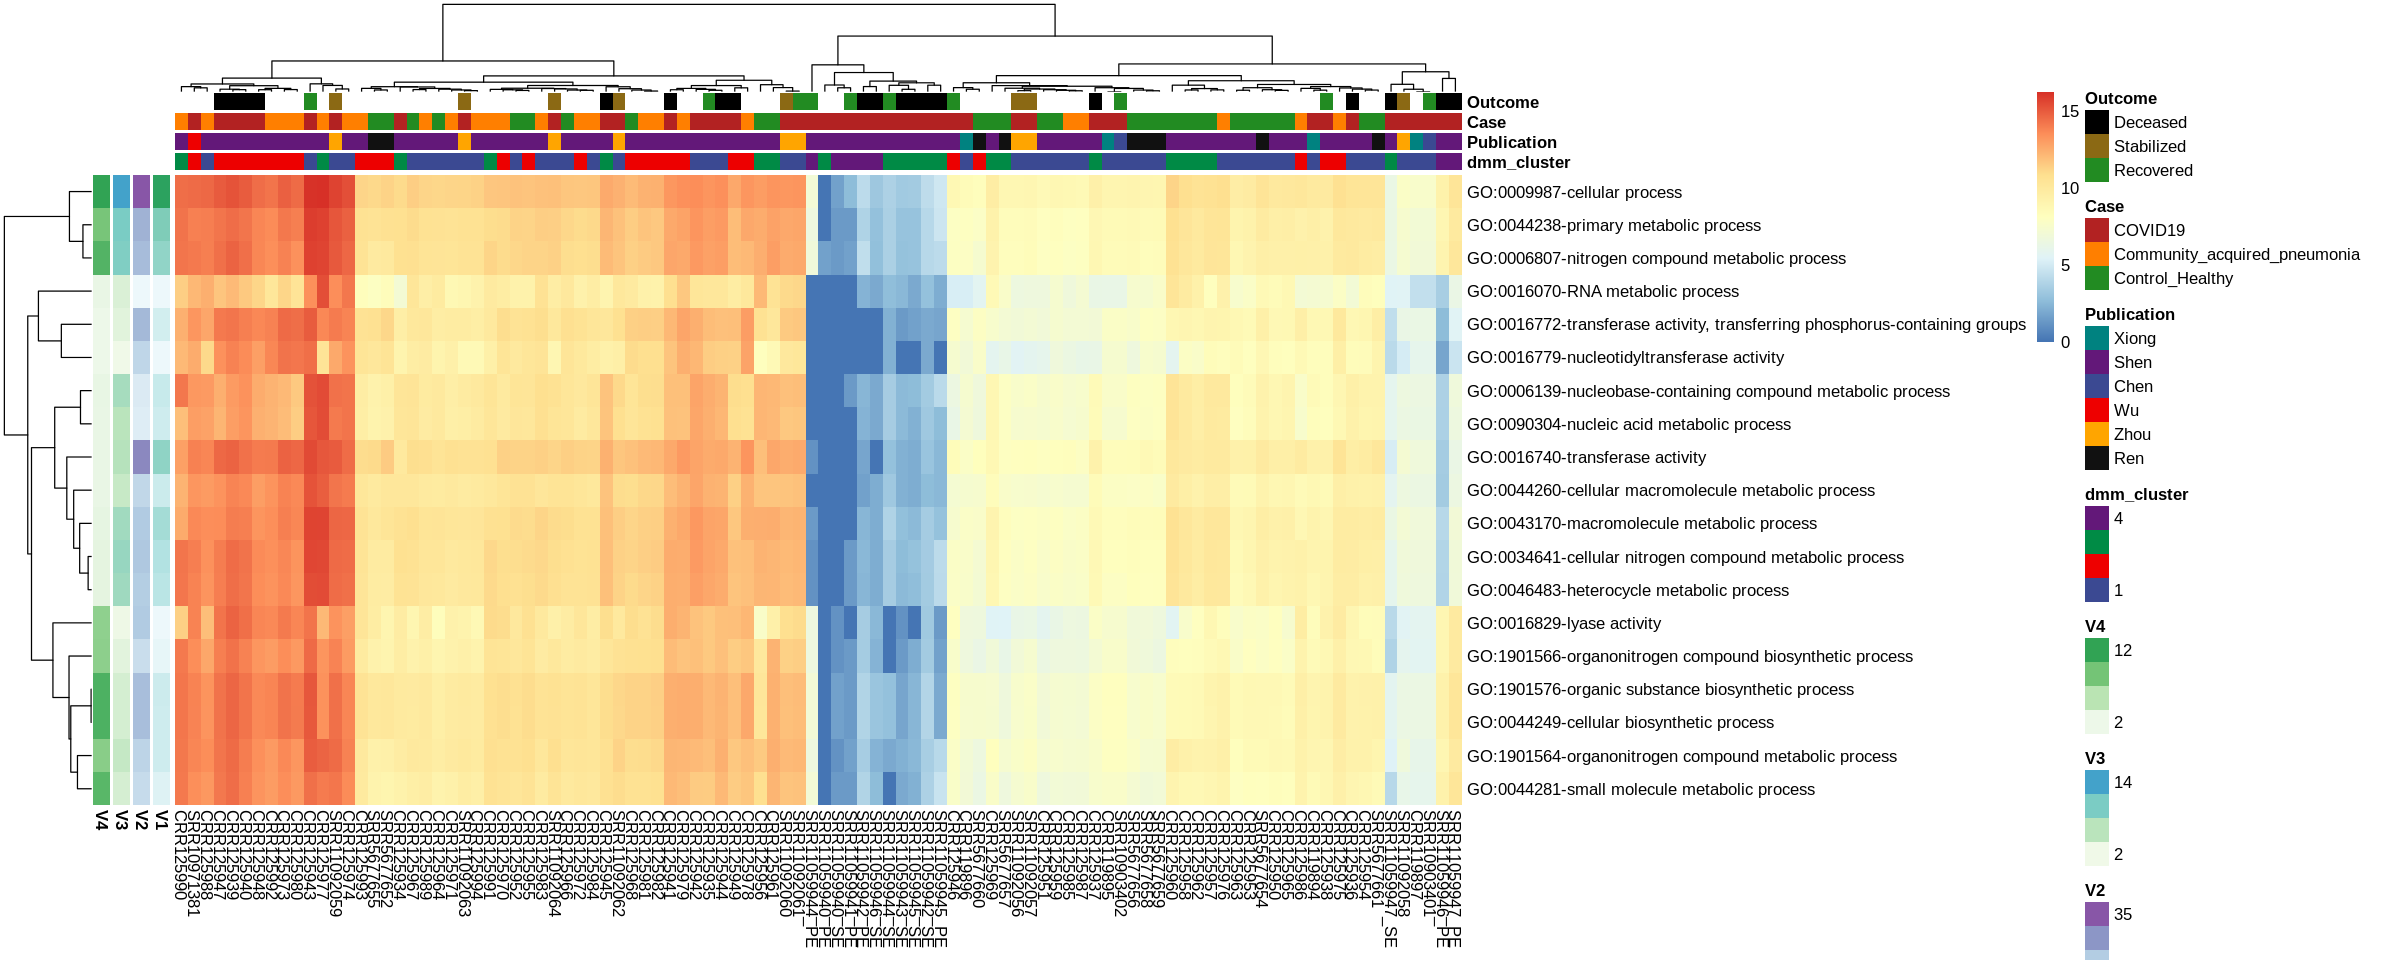

In [502]:
options(repr.plot.width=20, repr.plot.height=8)
xx <- pheatmap(mat = select3,
               color = colorRampPalette(rev(brewer.pal(n = 7, name ="RdYlBu")))(1000),
               annotation_col=df,
               annotation_colors = ann_colors,
               clustering_distance_rows = "euclidean",
               clustering_distance_cols = "euclidean",
              annotation_row = df_row)

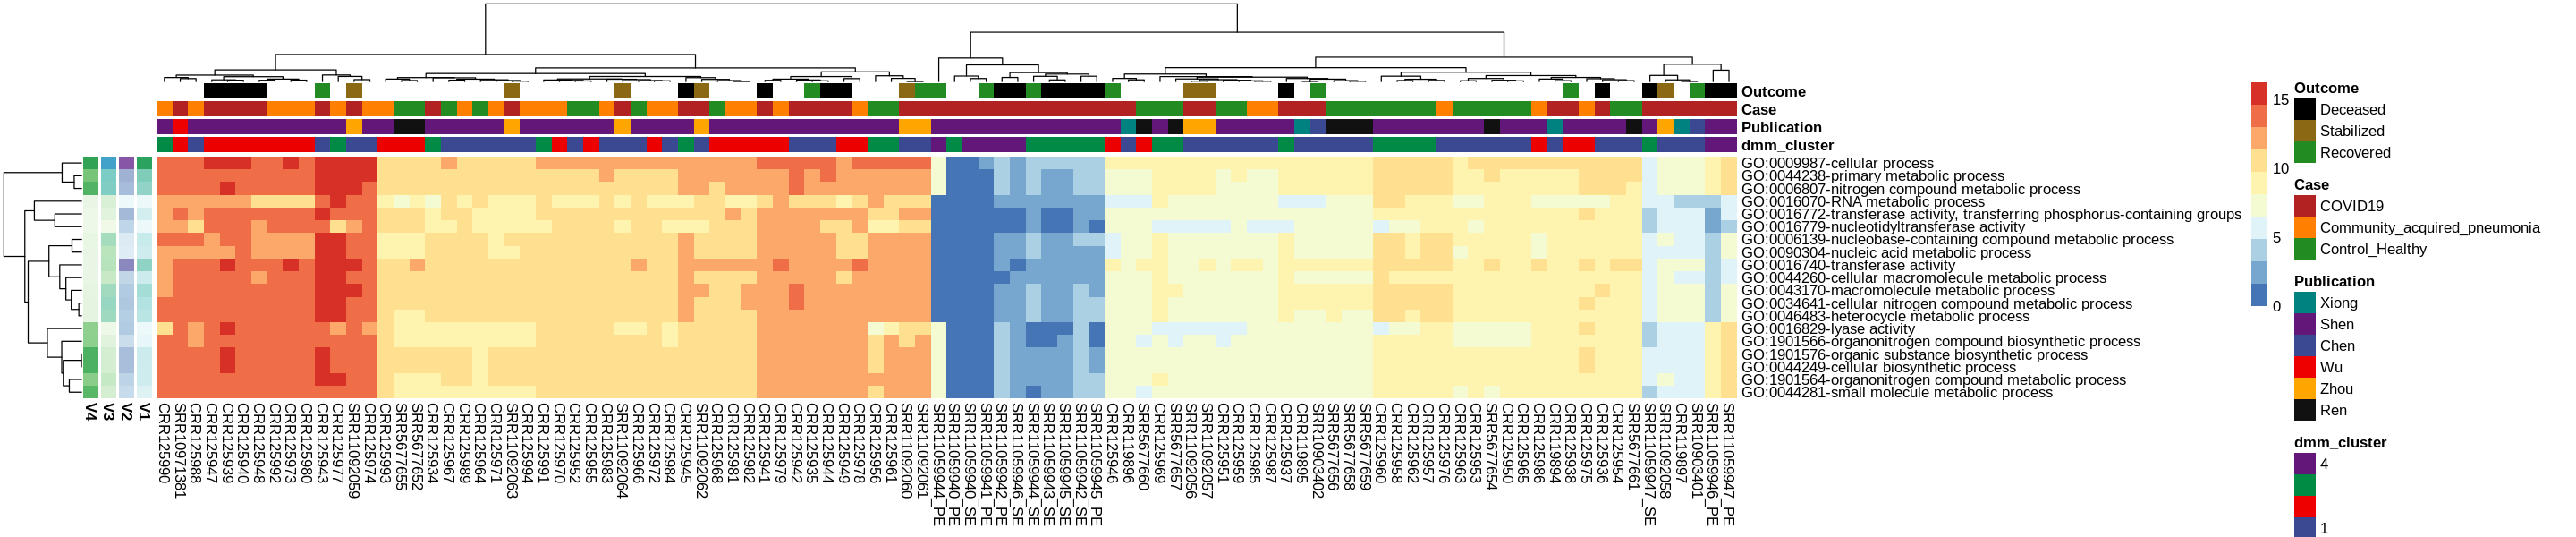

In [503]:
options(repr.plot.width=24, repr.plot.height=5)
xx <- pheatmap(mat = select2,
               color = colorRampPalette(rev(brewer.pal(n = 7, name ="RdYlBu")))(10),
               annotation_col=df,
               annotation_colors = ann_colors,
               clustering_distance_rows = "euclidean",
               clustering_distance_cols = "euclidean",
               annotation_row = df_row,
               cluster_row = T,
               cluster_col=T)

## OK GREAT JOB
### NEXT STEPS: 
#### REMOVE THE MIKALOVICH SAMPLES (DONE)
#### ADD A COLUMN FOR OUTCOME ON THE HEATMAP (DONE)

In [505]:
#BiocManager::install(c('FactoMineR','factoextra'))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



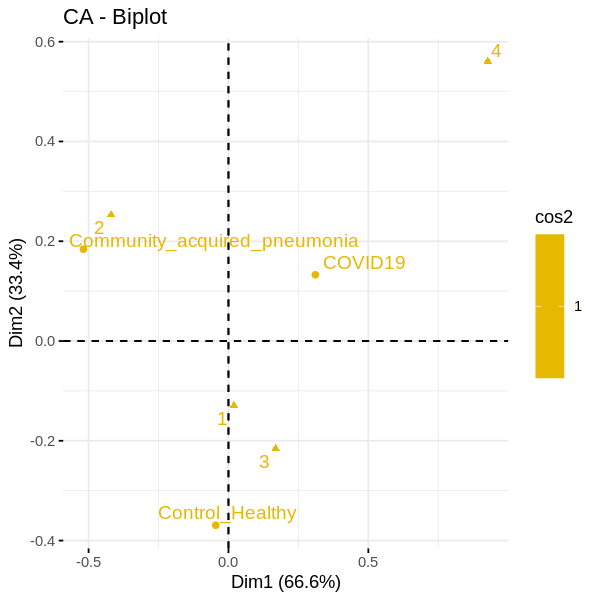

In [506]:
library('FactoMineR')
library('factoextra')
options(repr.plot.width=5, repr.plot.height=5)
a<-tally(~case+dmn,meta(bac_pseq_prune))
res.CA<-CA(a,graph=F)
#res.CA
fviz_ca_biplot(res.CA,
               repel=T,
               col.col="cos2",
               col.row="cos2",
               gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



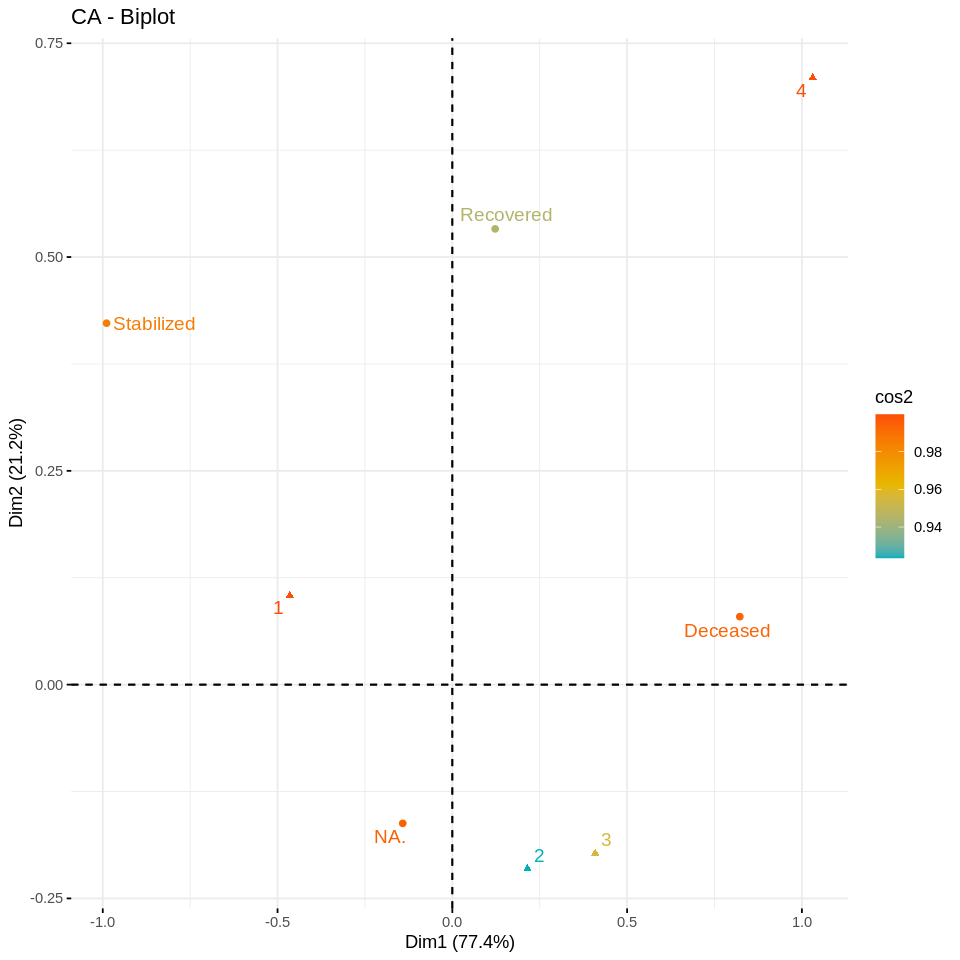

In [507]:
library('FactoMineR')
library('factoextra')
options(repr.plot.width=8, repr.plot.height=8)
a<-tally(~outcome+dmn,meta(bac_pseq_prune))
res.CA<-CA(a,graph=F)
#res.CA
fviz_ca_biplot(res.CA,
               repel=T,
               col.col="cos2",
               col.row="cos2",
               gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"))

In [ ]:
##################ANYTHING BELOW THIS LINE IS TRASH FOR NOW###########
####################################################
# Correlation between dmm groups and cases
#################################################




library(matrixTests)
p<-psmelt(bac_pseq_prune)
dmn_sum<-p%>%
  select(Sample,OTU,dmn,Abundance)%>%
  group_by(OTU,dmn)%>%
  pivot_wider(id_cols = c(Sample,dmn), names_from = OTU,values_from = Abundance)
write.table(dmn_sum, "dmn_sum.tsv",sep="\t")
# an example with offsets from Venables & Ripley (2002, p.189)
dmn_case<-pairwise.wilcox.test(p$Abundance, p$case,p.adjust.method = "BH")
dmn_wilcox<-pairwise.wilcox.test(p$Abundance, p$dmn,p.adjust.method = "BH")


p$lg<-log1p(p$Abundance)
p$dmn<-as_factor(p$dmn)
p$case<-factor(x = p$case, levels = c("Control_Healthy","Control_Sick","COVID19"))


library(lmerTest)
library(lmer)
case_dmn_glm <- lmer(lg ~ dmn +(dmn|case),data = p)
f<-ls_means(case_dmn_glm)

# b<-glm( lg ~ dmn+case, data = p, family = gaussian)
library(mosaic)
msummary(b)
b$coefficients
c<-anova(b)
d<-aov(b)
e<-TukeyHSD(d)
library(lmerTest)
f<-ls_means(case_dmn_glm)

msummary(e$case)
e$case
mat<-dmn_sum[,3:length(dmn_sum)]
krus_dmn<-col_kruskalwallis(x =mat,g = dmn_sum$dmn)
welch_dmn<-col_oneway_welch(x=mat, g=dmn_sum$dmn)

krus_dmn_sig<-krus_dmn%>%filter(pvalue<0.01)%>%arrange(pvalue)
welch_dmn_sig<-welch_dmn%>%filter(pvalue<0.01)%>%arrange(pvalue)

TukeyHSD(welch_dmn_sig)
library(mosaic)
msummary(welch_dmn_sig)
dim(krus_dmn_sig)
dim(welch_dmn_sig)
krus_sig
write.table(krus,"krus_dmn.tsv",sep = "\t")

colnames(krus_sig)
colnames(krus_sig)
krus_sig_names<-intersect(rownames(krus_case_sig), rownames(krus_dmn_sig))
welch_sig_names<-intersect(rownames(welch_case_sig), rownames(welch_dmn_sig))
sig_names<-intersect(krus_sig_names,welch_sig_names)